# Clean Slate: Suffolk County Data Analysis

> Prepared by Joel Tennyson for Code for Boston's [Clean Slate Project](https://github.com/codeforboston/clean-slate)

# Purpose
This notebook takes processed data from the Suffolk DA (merged_suff.csv) and answers the below questions and subquestions posed by the Citizens for Juvenile Justice (CfJJ). In each case, 'who is eligible' refers to the number of individuals who would have one or more charges that are potentially eligible for expungement. These questions are presented as listed [here](https://github.com/codeforboston/clean-slate/issues/152), with additional explanations and notes found under the Step 3 heading of this notebook.  

1) Who is eligible today? People with only one charge that is not part of the list of (ineligible) offenses.

2a) If we only change the number of offenses, how many are eligible based on only having one incident (that does not include an ineligible offense)?

2b) How many would be eligible if we only limited to only exclude sex-based offenses or murder?

2b.2) As 2b, but limited to no more than one incident.

3a) How many would be eligible based on who has not been found guilty (given current offenses that are eligible for expungement)?

3a.2) As 3a, but limited to no more than one incident.

3b) How many would be eligible based on who has not been found guilty, except murder or sex offenses?

---



# Step 0
Import libaries and create a Pandas dataframe from the Suffolk data


---



In [375]:
import requests
import pandas as pd
import datetime

In [376]:
# Create dataframe from processed Suffolk individual-level data
sf = pd.read_csv('../../data/processed/merged_suff.csv', encoding='utf8')
pd.set_option('display.max.columns', None)
pd.set_option('display.max_colwidth', None)

# Step 1
Data Cleaning, Derive Additional Columns Used For Analysis


---



**Note on Attempts**

It is impossible to determine the expungeability of most *attempted* crimes because not enough information is available about the nature of the crime being attempted. Instead of being marked with a 'yes' or 'no' in the 'Expungeable' column, these are marked with 'attempt.' The Clean Slate data team has determined that for the purposes of analysis, these attempts will be considered to be expungeable offenses. These attempt offenses make up a very small portion of the data, and this assumption should not have significant impact on the analysis.

In [377]:
# BEFORE any data is dropped, display some summary statistics on expungeability
total = len(sf)
expungeable = len(sf[sf['Expungeable'] == 'Yes'])
nonexpungeable = len(sf[sf['Expungeable'] == 'No'])
attempts = len(sf[sf['Expungeable'] == 'Attempt'])
cmr = len(sf[sf['CMRoffense'] == 'yes'])
missing = len(sf[sf['Expungeable'].isna()])

print('There are', total, 'offenses total in the Suffolk data.')
print(expungeable, 'are marked as expungeable', '({:.2%})'.format(expungeable/total))
print(nonexpungeable, 'are marked as nonexpungeable', '({:.2%})'.format(nonexpungeable/total))
print(attempts, 'are marked as attempts', '({:.2%})'.format(attempts/total))
print(cmr, 'are CMR offenses', '({:.2%})'.format(cmr/total))
print(missing, 'are missing an expungeability determination', '({:.2%})'.format(missing/total))

There are 303270 offenses total in the Suffolk data.
215374 are marked as expungeable (71.02%)
82038 are marked as nonexpungeable (27.05%)
1503 are marked as attempts (0.50%)
2445 are CMR offenses (0.81%)
0 are missing an expungeability determination (0.00%)


In [378]:
# Display the number of 'attempt' offenses in the Suffolk dataset, and mark them as expungeable
attempts = len(sf[sf['Expungeable'] == 'Attempt'])
total = len(sf)
print('There are', attempts, 'charges marked as attempts in the Suffolk data, comprising', '{:.2%}'.format(attempts/total), 'of the data.')

sf.loc[sf['Expungeable'] == 'Attempt', 'Expungeable'] = 'Yes'

There are 1503 charges marked as attempts in the Suffolk data, comprising 0.50% of the data.


In [379]:
# Drop all CMR offenses from the dataframe
total_CMR_offenses = sf[sf['CMRoffense'] == 'yes']['CMRoffense'].count()
sf = sf[sf['CMRoffense'] != 'yes']
sf = sf.drop(columns = ['CMRoffense'])
print(total_CMR_offenses, 'CMR offenses have been dropped, leaving', len(sf), 'total offenses')

2445 CMR offenses have been dropped, leaving 300825 total offenses


In [380]:
# Drop offenses with no offense date
total_lacking_date = sf['Offense Date'].isna().sum()
sf = sf[~sf['Offense Date'].isna()]
print(total_lacking_date, 'offenses without an offense date have been dropped, leaving', len(sf), 'total offenses')

2387 offenses without an offense date have been dropped, leaving 298438 total offenses


In [381]:
# Add column: Years Since Offense
reference_date = datetime.date(2020, 9, 1)
sf['Offense Date'] = pd.to_datetime(sf['Offense Date']).dt.date
sf['Years Since Offense'] = (reference_date - sf['Offense Date'])/pd.Timedelta(1, 'D')/365

sf['Years Since Offense'].describe()

count    298438.000000
mean          5.154985
std           2.508510
min           1.723288
25%           3.484932
50%           5.046575
75%           6.526027
max          85.441096
Name: Years Since Offense, dtype: float64

In [382]:
# Add column: Total Offenses
sf['Total Offenses'] = sf.groupby('Person ID')['Person ID'].transform('count')
sf['Total Offenses'].describe()

count    298438.000000
mean          9.153861
std          17.742343
min           1.000000
25%           2.000000
50%           5.000000
75%          11.000000
max         352.000000
Name: Total Offenses, dtype: float64

In [383]:
# Add column: Incidents
sf['Incidents'] = sf.groupby(['Person ID'])['Offense Date'].transform('nunique')
sf['Incidents'].describe()

count    298438.000000
mean          3.272452
std           3.868787
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          45.000000
Name: Incidents, dtype: float64

In [384]:
# Add column: Incident Expungeable
sf['Temp Expungeable'] = (sf['Expungeable'] == 'Yes')
sf['Incident Expungeable'] = sf.groupby(['Person ID', 'Offense Date'])['Temp Expungeable'].transform('min')
sf = sf.drop(columns=['Temp Expungeable'])

In [385]:
# Add column: Incident Sex Murder
sf['Temp Sex Murder'] = (sf['sex'] == 1) | (sf['murder'] ==1)
sf['Incident Sex Murder'] = sf.groupby(['Person ID', 'Offense Date'])['Temp Sex Murder'].transform('max')
sf = sf.drop(columns=['Temp Sex Murder'])

**Note on Guilty Dispositions**

The list of guilty dispositions is largely based on the determinations made in [this file](https://docs.google.com/spreadsheets/d/1axzGGxgQFPwpTw7EbBlC519L43fOkqC5/edit?rtpof=true).

Some offenses have no associated disposition data. Currently, these are being treated as non-guilty offenses for this analysis. To treat them as guilty instead, switch the -1 below to a 2.

In [386]:
# Add column: Guilty
guilty_disposition_reasons = ['Guilty - Committed', 'Guilty - Probation', 'Dismissed for Agreed Plea', 'Guilty - Fine', 'Guilty - Suspended Sentence', 'Guilty', 'Guilty - Filed', 'Guilty - Split Sentence', 'Responsible - Fine C277S70', 'Guilty - Lesser Offense', 'Delinquent - Committed', 'Delinquent - Probation', 'Delinquent - Filed', 'Delinquent - Fine', 'Delinquent - Suspended', 'Delinquent']
guilty_dispositions = ['Plea']
sf['Guilty'] = sf['Description Disposition Reason'].isin(guilty_disposition_reasons)
# When disposition reason is missing and disposition is not, use disposition to determine guilty or nonguilty
sf.loc[(sf['Description Disposition Reason'].isnull() & (sf['Disposition'].notnull())), 'Guilty'] = 0
sf.loc[(sf['Description Disposition Reason'].isnull() & (sf['Disposition'].notnull()) & (sf['Disposition'].isin(guilty_dispositions))), 'Guilty'] = 1
# Guilty is -1 if there is no disposition reason at all AND there is no disposition
sf.loc[(sf['Description Disposition Reason'].isnull() & (sf['Disposition'].isnull())), 'Guilty'] = -1

In [387]:
# Add column: Incident Guilty
sf['Incident Guilty'] = sf.groupby(['Person ID', 'Offense Date'])['Guilty'].transform('max')

In [388]:
# Given a dataframe of offenses, this function prints the number of offenses that occured at least 3 years prior to reference_date,
# then the number that occured at least 7 years prior
def date_range(x):
    greater3 = x.loc[(x['Years Since Offense'] > 3)]['Person ID'].nunique()
    greater7 = x.loc[(x['Years Since Offense'] > 7)]['Person ID'].nunique()

    print(greater3, "occured more than 3 years before", reference_date)
    print(greater7, "occured more than 7 years before", reference_date)

In [389]:
# Given a subset of the sf dataframe, this function determines the number of unique individuals found in that subset
# and determines the percent that number of individuals is of the full sf dataframe
total_people = sf['Person ID'].nunique()

def get_result(x):
  people_in_x = x['Person ID'].nunique()
  percent = '{:.2%}'.format(people_in_x/total_people)
  return people_in_x, percent

# Step 2
Summary of Offense and Incident Distribution


---



In [390]:
# Display distribution of # of charges by person ID
print(sf['Total Offenses'].describe())
print('\n cutting off top 1%: \n', sf['Total Offenses'].loc[sf['Total Offenses']< sf['Total Offenses'].quantile(.99)].describe())

count    298438.000000
mean          9.153861
std          17.742343
min           1.000000
25%           2.000000
50%           5.000000
75%          11.000000
max         352.000000
Name: Total Offenses, dtype: float64

 cutting off top 1%: 
 count    295386.000000
mean          7.952076
std           8.051523
min           1.000000
25%           2.000000
50%           5.000000
75%          11.000000
max          47.000000
Name: Total Offenses, dtype: float64


<AxesSubplot:title={'center':'Top Ten Overall Offenses'}, ylabel='Charge'>

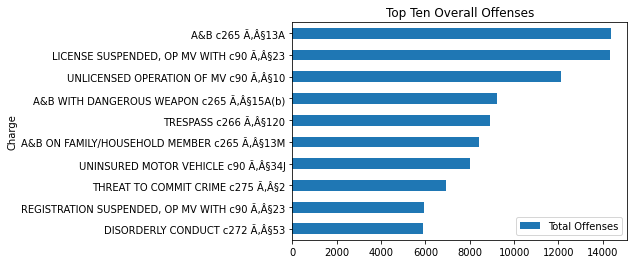

In [391]:
# TOP TEN OVERALL OFFENSES
overall_offenses = sf.groupby(['Charge'])['Charge'].count().reset_index(name='Total Offenses').sort_values(['Total Offenses'], ascending=False)
overall_offenses.head(10).sort_values(['Total Offenses'], ascending=True).plot.barh(x='Charge', title='Top Ten Overall Offenses')

<AxesSubplot:title={'center':'Top Ten Expungeable Offenses'}, ylabel='Charge'>

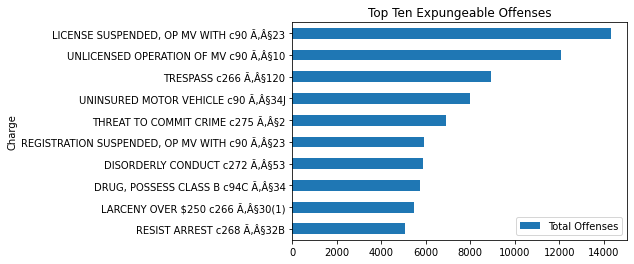

In [392]:
# TOP TEN EXPUNGEABLE OFFENSES
expungeable_offenses = sf[sf['Expungeable'] == 'Yes'].groupby(['Charge'])['Charge'].count().reset_index(name='Total Offenses').sort_values(['Total Offenses'], ascending=False)
expungeable_offenses.head(10).sort_values(['Total Offenses'], ascending=True).plot.barh(x='Charge', title='Top Ten Expungeable Offenses')

<AxesSubplot:title={'center':'Top Ten Nonexpungeable Offenses'}, ylabel='Charge'>

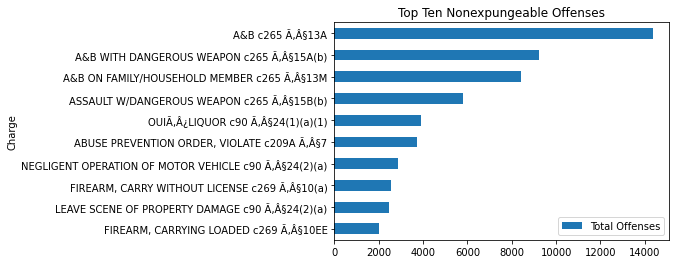

In [393]:
# TOP TEN NONEXPUNGEABLE OFFENSES
nonexpungeable_offenses = sf[sf['Expungeable'] == 'No'].groupby(['Charge'])['Charge'].count().reset_index(name='Total Offenses').sort_values(['Total Offenses'], ascending=False)
nonexpungeable_offenses.head(10).sort_values(['Total Offenses'], ascending=True).plot.barh(x='Charge', title='Top Ten Nonexpungeable Offenses')

In [394]:
# SUMMARY STATS ON OFFENSES AND INCIDENTS
total_count = sf['Person ID'].nunique()
total = ['Total individuals', total_count, '{:,.2%}'.format(1)]

oneoff_count = sf[sf['Total Offenses']==1]['Person ID'].nunique()
oneoff = ['Individuals with a single offense', oneoff_count, '{:,.2%}'.format(oneoff_count/total_count)]

oneinc_count = sf[sf['Incidents']==1]['Person ID'].nunique()
oneinc = ['Individuals with a single incident', oneinc_count, '{:,.2%}'.format(oneinc_count/total_count)]

off_one_off_count = sf[sf['Total Offenses']==1].shape[0]
off_one_off = ['Offenses committed by individuals with one offense', off_one_off_count, '{:,.2%}'.format(off_one_off_count/sf.shape[0])]

inc_one_inc_count = sf[sf['Incidents']==1].groupby(['Person ID', 'Offense Date']).ngroups
inc_one_inc = ['Incidents committed by individuals with one incident', inc_one_inc_count, '{:,.2%}'.format(inc_one_inc_count/sf.groupby(['Person ID', 'Offense Date']).ngroups)]

stats = [total, oneoff, oneinc, off_one_off, inc_one_inc]
statsdf = pd.DataFrame(stats, columns = ['Question', 'Number', 'Percent Total'])
statsdf = statsdf.set_index('Question')
statsdf.style.format({'Number' : '{:,}'})
statsdf

,Number,Percent Total
Question,,
Total individuals,90440,100.00%
Individuals with a single offense,33552,37.10%
Individuals with a single incident,65964,72.94%
Offenses committed by individuals with one offense,33552,11.24%
Incidents committed by individuals with one incident,65964,44.77%


In [395]:
# SUMMARY STATS ON NONEXPUNGEABLE SEX AND MURDER CHARGES
total_off_count = sf['Charge'].count()
total_off = ['Total offenses', total_off_count, 'N/A']

total_inc_count = sf.groupby(['Person ID', 'Offense Date']).ngroups
total_inc = ['Total cases (incidents)', total_inc_count, 'N/A']

sex_off_count = sf[sf['sex'] == 1]['sex'].count()
sex_off = ['Sex offenses', sex_off_count, '{:,.2%}'.format(sex_off_count/total_off_count)]

murder_off_count = sf[sf['murder'] == 1]['murder'].count()
murder_off = ['Murders', murder_off_count, '{:,.2%}'.format(murder_off_count/total_off_count)]

sex_murder_inc_count = sf[sf['Incident Sex Murder']  == 1].groupby(['Person ID', 'Offense Date']).ngroups
sex_murder_inc = ['Incidents with sex or murder', sex_murder_inc_count, '{:,.2%}'.format(sex_murder_inc_count/total_inc_count)]

stats = [sex_off, murder_off, sex_murder_inc, total_inc, total_off]
statsdf = pd.DataFrame(stats, columns = ['Murder Sex Stats','Number', 'Percent Total'])
statsdf = statsdf.set_index('Murder Sex Stats')
statsdf.style.format({'Number' : '{:,}'})
statsdf

,Number,Percent Total
Murder Sex Stats,,
Sex offenses,7130,2.39%
Murders,1401,0.47%
Incidents with sex or murder,5754,3.91%
Total cases (incidents),147346,N/A
Total offenses,298438,N/A


# Step 3
Analysis to answer the questions posed by Citizens for Juvenile Justice


---

**Question 1**

**Who is eligible today? People with only one charge that is not part of the list of (ineligible) offenses.**

Notes:
*   It is additionally true that a misdemeanor can only be expunged three or more years after the date of the incident, and a felony can only be expunged seven or more years after the date of the incident.

In [396]:
eligible = sf.loc[
  (sf['Total Offenses']==1) &
  (sf['Expungeable']=='Yes')
]

q1 = 'Q1', 'Eligible Today: No more than one offense, offense must be expungeable', get_result(eligible)
print(q1)
date_range(eligible)

('Q1', 'Eligible Today: No more than one offense, offense must be expungeable', (23784, '26.30%'))
19934 occured more than 3 years before 2020-09-01
5040 occured more than 7 years before 2020-09-01


**Question 2**

**2A: If we only change the number of offenses, how many are eligible based on only having one incident (that does not include an ineligible offense)?**

Notes:
* Making the assumption based on the 06/26/<wbr>20 meeting notes that an 'incident' is defined as the sum of all charges for an individual on a single day. In theory, someone could probably be charged in two separate instances on a single day, but this is likely rare.
* For all incident-based analysis in this notebook, we assume that a single non-expungeable offense under the bundle of the incident makes the entire incident non-expungeable. Same for the analysis of murder or sex crimes.

In [397]:
eligible = sf.loc[
  (sf['Incidents']==1) &
  (sf['Incident Expungeable']==True)
]

q2a = 'Q2A', 'No more than one incident, all offenses must be expungeable', get_result(eligible)
print(q2a)
date_range(eligible)

('Q2A', 'No more than one incident, all offenses must be expungeable', (43066, '47.62%'))
36213 occured more than 3 years before 2020-09-01
9053 occured more than 7 years before 2020-09-01


**2B) How many would be eligible if we only limited to only exclude sex-based offenses or murder?**

In [398]:
eligible = sf.loc[
  (sf['Incident Sex Murder']==False)
]

print('Q2B) (Any number of incidents, only offenses related to sex or murder are nonexpungeable)')
q2b = 'Q2B', 'Any number of incidents, only offenses related to sex or murder are nonexpungeable', get_result(eligible)
print(q2b)
date_range(eligible)

Q2B) (Any number of incidents, only offenses related to sex or murder are nonexpungeable)
('Q2B', 'Any number of incidents, only offenses related to sex or murder are nonexpungeable', (87713, '96.98%'))
75730 occured more than 3 years before 2020-09-01
20715 occured more than 7 years before 2020-09-01


**2B.2) How many would be eligible if we only limited to only exclude sex-based offenses or murder?**

Notes:
*   Same as 2B above, but this time expungeability requires a person to have no more than one incident.

In [399]:
eligible = sf.loc[
  (sf['Incidents']==1) &
  (sf['Incident Sex Murder']==False)
]

q2b2 = 'Q2B.2', 'No more than one incident, only offenses related to sex or murder are nonexpungeable', get_result(eligible)
print(q2b2)
date_range(eligible)

('Q2B.2', 'No more than one incident, only offenses related to sex or murder are nonexpungeable', (63519, '70.23%'))
52754 occured more than 3 years before 2020-09-01
12439 occured more than 7 years before 2020-09-01


**Question 3**

**3A) How many would be eligible if we only limited to only exclude sex-based offenses or murder?**

Notes:
*   Having multiple offenses or incidents does not impact expungeability for this sub-question.



In [400]:
eligible = sf.loc[
  (sf['Incident Expungeable']==True) &
  (sf['Incident Guilty']<1)
]

q3a = 'Q3A', 'Any number of incidents, no guilty dispositions, all offenses expungeable', get_result(eligible)
print(q3a)
date_range(eligible)

('Q3A', 'Any number of incidents, no guilty dispositions, all offenses expungeable', (55009, '60.82%'))
47035 occured more than 3 years before 2020-09-01
12271 occured more than 7 years before 2020-09-01


**3A.2) How many would be eligible if we only limited to only exclude sex-based offenses or murder?**

Notes:
*   Same as 3A above, but this time expungeability requires a person to have no more than one incident.

In [401]:
eligible = sf.loc[
  (sf['Incidents'] == 1) &
  (sf['Incident Expungeable']==True) &
  (sf['Incident Guilty']<1)
]

q3a2 = 'Q3A.2', 'No more than one incident, no guilty dispositions, all offenses expungeable', get_result(eligible)
print(q3a2)
date_range(eligible)

('Q3A.2', 'No more than one incident, no guilty dispositions, all offenses expungeable', (36173, '40.00%'))
30256 occured more than 3 years before 2020-09-01
7545 occured more than 7 years before 2020-09-01


**3B) How many would be eligible based on who has not been found guilty, except murder or sex offenses?**

Notes:
*   Having multiple offenses or incidents does not impact expungeability for this sub-question.

In [402]:
eligible = sf.loc[
  #(sf['Incident Expungeable']==True) &
  (sf['Incident Guilty']<1) &
  (sf['Incident Sex Murder']==False)
]

q3b = 'Q3B', 'Any number of incidents, no guilty dispositions, only offenses related to sex or murder are nonexpungeable', get_result(eligible)
print(q3b)
date_range(eligible)

('Q3B', 'Any number of incidents, no guilty dispositions, only offenses related to sex or murder are nonexpungeable', (76407, '84.48%'))
64939 occured more than 3 years before 2020-09-01
16741 occured more than 7 years before 2020-09-01


**3B.2) How many would be eligible based on who has not been found guilty, except murder or sex offenses?**

Notes:
*   Same as 3B above, but this time expungeability requires a person to have no more than one incident.

In [403]:
eligible = sf.loc[
  (sf['Incidents'] == 1) &
  #(sf['Incident Expungeable']==True) &
  (sf['Incident Guilty']<1) &
  (sf['Incident Sex Murder']==False)
]

q3b2 = 'Q3B.2', 'No more than one incident, no guilty dispositions, only offenses related to sex or murder are nonexpungeable', get_result(eligible)
print(q3b2)
date_range(eligible)

('Q3B.2', 'No more than one incident, no guilty dispositions, only offenses related to sex or murder are nonexpungeable', (53679, '59.35%'))
44096 occured more than 3 years before 2020-09-01
10279 occured more than 7 years before 2020-09-01


**Summary of Analysis**

In [404]:
stats = [q1, q2a, q2b, q2b2, q3a, q3a2, q3b, q3b2]
statsdf = pd.DataFrame(stats, columns = ['q', 'Question', 'A'])
statsdf[['Individuals', 'Percent']] = pd.DataFrame(statsdf['A'].tolist())
statsdf = statsdf.drop('A', axis=1)
statsdf = statsdf.set_index('q')

statsdf.style.format({'Eligible Individuals' : '{:,}'})
statsdf

,Question,Individuals,Percent
q,,,
Q1,"Eligible Today: No more than one offense, offense must be expungeable",23784,26.30%
Q2A,"No more than one incident, all offenses must be expungeable",43066,47.62%
Q2B,"Any number of incidents, only offenses related to sex or murder are nonexpungeable",87713,96.98%
Q2B.2,"No more than one incident, only offenses related to sex or murder are nonexpungeable",63519,70.23%
Q3A,"Any number of incidents, no guilty dispositions, all offenses expungeable",55009,60.82%
Q3A.2,"No more than one incident, no guilty dispositions, all offenses expungeable",36173,40.00%
Q3B,"Any number of incidents, no guilty dispositions, only offenses related to sex or murder are nonexpungeable",76407,84.48%
Q3B.2,"No more than one incident, no guilty dispositions, only offenses related to sex or murder are nonexpungeable",53679,59.35%
